<a href="https://colab.research.google.com/github/siavashadpey/CS224W_Project/blob/main/notebooks/Project_Milestone_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis for PDBBind CleanSplit Datasets

## Setup


In [ ]:
# If GCS data mount is not populated perform following steps in vm:
"""
# Stop/Unmount any previous attempts
# Try to unmount the directory in case a previous attempt left it mounted
# If this fails, it's fine, it just means it wasn't mounted.
fusermount -u ~/gcs_pdbbind_mount

# If /gcs_pdbbind_mount not visible in file system create dir for local mount point:
mkdir ~/gcs_pdbbind_mount

# Replace BUCKET_NAME and DIRECTORY_PATH
BUCKET_NAME="cs224w-2025-mae-gnn-bucket"
DIRECTORY_PATH="data/GEMS_pytorch_datasets"

gcsfuse --only-dir "$DIRECTORY_PATH" -o allow_other --implicit-dirs "$BUCKET_NAME" ~/gcs_pdbbind_mount

#Verify the Mount:
ls -l ~/gcs_pdbbind_mount

# You should see your .pt files listed here, proving the mount worked.
"""

In [5]:
!pip install torch_geometric pandas matplotlib
!pip install "numpy<2"

In [6]:
# Imports
import sys
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Set style for better visualization
sns.set_theme(style="whitegrid")

In [7]:
print("torch version:", torch.__version__)
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)

torch version: 1.13.1+cu117
numpy version: 1.26.4
pandas version: 2.3.3


In [9]:
# CONSTANTS

# Need to download Dataset.py from GEMS directory locally onto vm first
# git clone http://github.com/camlab-ethz/GEMS.git
# Define root path of cloned GEMS repo
GEMS_REPO_ROOT = os.path.expanduser('~/GEMS')

# Define the directory path where pre-processed .pt dataset files are located
DATA_DIR = os.path.join(os.path.expanduser('~'), 'gcs_pdbbind_mount')

# List of dataset files to analyze
DATASET_FILES = [
    # '00AEPL_casf2013.pt',
    # '00AEPL_casf2013_indep.pt',
    '00AEPL_casf2016.pt',
    #'00AEPL_casf2016_indep.pt',
    '00AEPL_train_cleansplit.pt',
    # '00AEPL_train_pdbbind.pt'
]

DATASET_FILES_DICT = {
    'Train': '00AEPL_train_cleansplit.pt',
    'Test': '00AEPL_casf2016.pt'
}

ALL_ATOMS = ['B', 'C', 'N', 'O', 'P', 'S', 'Se', 'metal', 'halogen']

ATOM_HYBRIDIZATION_TYPES = ["HybridizationType.S", "HybridizationType.SP", "HybridizationType.SP2", "HybridizationType.SP2D", "HybridizationType.SP3", "HybridizationType.SP3D", "HybridizationType.SP3D2", "HybridizationType.UNSPECIFIED"]
TOTAL_NUM_H_S = ["Num_H.0", "Num_H.1", "Num_H.2", "Num_H.3", "Num_H.4"]
DEGREES = ['Degree.0', 'Degree.1', 'Degree.2', 'Degree.3', 'Degree.4', 'Degree.5', 'Degree.6', 'Degree.7', 'Degree.8', 'Degree.OTHER']
CHIRALITIES = ['Chirality.CHI_UNSPECIFIED', 'Chirality.CHI_TETRAHEDRAL_CW', 'Chirality.CHI_TETRAHEDRAL_CCW', 'Chirality.OTHER']

AMINO_ACIDS = ["ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY", "HIS", "ILE", "LEU",
            "LYS", "MET", "PHE", "PRO", "SER", "THR", "TRP", "TYR", "VAL"]

LIGAND_FEATURE_MAP = ALL_ATOMS + ["IsInRing"] + ATOM_HYBRIDIZATION_TYPES + \
                    ["FORMAL_CHARGE", "IS_AROMATIC", "MASS/100", ] + TOTAL_NUM_H_S + \
                    DEGREES + CHIRALITIES
FULL_FEATURE_MAP = LIGAND_FEATURE_MAP + AMINO_ACIDS

EDGE_FEATURE_MAP = ["COVALENT_BOND", "SELF_LOOP", "NON-COVALENT_BOND", "EDGE_LENGTH/10", "EDGE_LENGTH/10", "EDGE_LENGTH/10", "EDGE_LENGTH/10" ] + \
                   ["BOND_TYPE_0", "BOND_TYPE_1.0", "BOND_TYPE_1.5", "BOND_TYPE_2.0", "BOND_TYPE_3.0"] + \
                   ["IS_CONJUGATED", "IS_IN_RING", "BOND_STEREO.NONE", "BOND_STEREO.ANY", "BOND_STEREO.E", "BOND_STEREO.Z", "BOND_STEREO.CIS", "BOND_STEREO.TRANS"]


In [10]:
# Dynamic Import of Custom Datasets Class
# Add the directory to Python's search path.
print(f"Attempting to load custom Dataset class...")

try:
  # Add GEMS root to sys.path
  if GEMS_REPO_ROOT not in sys.path:
    sys.path.append(GEMS_REPO_ROOT)
    print(f"Added {GEMS_REPO_ROOT} to sys.path")

    # Import custom Dataset class from the cloned repo
    from Dataset import Dataset as GEMS_Dataset
    print("Successfully imported custom Dataset class")

    # Import the necessarty PyG components
    from torch_geometric.data import Data #, Dataset

except ImportError as e:
    raise RuntimeError(f"FATAL ERROR importing GEMS Dataset class: {e}")


Attempting to load custom Dataset class...
Added /home/jupyter/GEMS to sys.path
Successfully imported custom Dataset class


## Data Extraction and Visualization Functions

In [11]:
def extract_metrics(data_list):
    """Iterates through list of GEMS datasets and extracts metrics."""
    metrics = []

    num_features = data_list[0].x.size(1)
    for i, data in enumerate(data_list):
        # Affinity is the y label
        affinity = data.y.item()

        # ID (Assuming is stored in 'id' attribute)
        pdb_id = getattr(data, 'id', f'Complex_{i}')

        # Extract Graph Size Metrics
        # node features (x): shape is [num_atoms, num_features]
        num_nodes = data.x.size(0)

        # Edge index: shape is: [2, num_edges]
        num_edges = data.edge_index.size(1)

        [n_nodes, n_ligand_nodes, n_protein_nodes] = data.n_nodes.numpy()

        # Isolate ligand rows
        ligand_x = data.x[:n_ligand_nodes]

        # Slice the tensor to only get the atom on-hot columns
        ligand_heavy_atoms_oh = ligand_x[:, :len(ALL_ATOMS)]
        is_heavy_atom = (ligand_heavy_atoms_oh.any(dim=1)).float()
        heavy_atom_count = is_heavy_atom.sum().item()

        # Isolate protein rows
        protein_x = data.x[n_ligand_nodes:]

        # Slice the tensor to only get the amino acid one-hot columns (last 20 cols)
        protein_aa_oh = protein_x[:, num_features - len(AMINO_ACIDS):]
        protein_aa_counts = protein_aa_oh.sum(dim=0)

        # convert to frequency normalization
        protein_aaf = (protein_aa_counts/ n_protein_nodes).cpu().numpy().tolist()

        # Feature counts
        #feature_counts_tensor = torch.sum(data.x, dim=0)

        # Append the aggregated features to the list
        record = {
            'PDB_ID': pdb_id,
            'Affinity': affinity,
            'Num_Nodes': num_nodes,
            'Num_Ligand_Atoms': n_ligand_nodes,
            'Num_Ligand_Heavy_Atoms': heavy_atom_count,
            'Num_Protein_Amino_Acid_Nodes': n_protein_nodes,
            'Protein_Amino_Acid_Frequency': protein_aaf,
            'Num_Edges': num_edges,
            'Density': num_edges / num_nodes,
        }

        # # Add feature counts dynamically
        # for j, feature_name in enumerate(FULL_FEATURE_MAP):
        #     record[feature_name] = feature_counts_tensor[j].item()

        metrics.append(record)

    return pd.DataFrame(metrics)

In [12]:
def extract_node_features(data_list):
    """Iterates through list of GEMS datasets and extracts node features."""
    metrics = []

    num_features = data_list[0].x.size(1)
    for i, data in enumerate(data_list):
        [n_nodes, n_ligand_nodes, n_protein_nodes] = data.n_nodes.numpy()

        # Isolate ligand rows
        ligand_x = data.x[:n_ligand_nodes]

        # Slice the tensor to only get the atom on-hot columns
        ligand_heavy_atoms_oh = ligand_x[:, :len(ALL_ATOMS)]
        is_heavy_atom = (ligand_heavy_atoms_oh.any(dim=1)).float()
        heavy_atom_count = is_heavy_atom.sum().item()

        # Isolate protein rows
        protein_x = data.x[n_ligand_nodes:]

        # Slice the tensor to only get the amino acid one-hot columns (last 20 cols)
        protein_aa_oh = protein_x[:, num_features - len(AMINO_ACIDS):]
        protein_aa_counts = torch.sum(protein_aa_oh, dim=0)

        # convert to frequency normalization
        protein_aaf = (protein_aa_counts/ n_protein_nodes).cpu().numpy().tolist()

        # Feature counts
        ligand_feature_counts_tensor = torch.sum(ligand_x, dim=0)
        protein_feature_counts_tensor = torch.sum(protein_x, dim=0)

        # Append the aggregated features to the list
        record = {
            'Num_Ligand_Atoms': n_ligand_nodes,
            'Num_Ligand_Heavy_Atoms': heavy_atom_count,
            'Num_Protein_Amino_Acid_Nodes': n_protein_nodes,
            'Protein_Amino_Acid_Frequency': protein_aaf,
        }

        # Add feature counts dynamically
        for j, feature_name in enumerate(LIGAND_FEATURE_MAP):
            record[feature_name] = ligand_feature_counts_tensor[j].item()

        for j, feature_name in enumerate(AMINO_ACIDS):
            record[feature_name] = protein_feature_counts_tensor[j].item()

        metrics.append(record)

    return pd.DataFrame(metrics)

In [13]:
def extract_edge_features(data_list):
    """Iterates through list of GEMS datasets and extracts edge features."""
    metrics = []

    num_features = data_list[0].x.size(1)
    for i, data in enumerate(data_list):
        [n_nodes, n_ligand_nodes, n_protein_nodes] = data.n_nodes.numpy()

        # Isolate ligand rows
        ligand_x = data.x[:n_ligand_nodes]

        # Isolate protein rows
        protein_x = data.x[n_ligand_nodes:]

        # Feature counts
        edge_feature_counts_tensor = torch.sum(data.edge_attr, dim=0)

        # Append the aggregated features to the list
        record = {}

        # Add feature counts dynamically
        for j, feature_name in enumerate(EDGE_FEATURE_MAP):
            record[feature_name] = edge_feature_counts_tensor[j].item()

        metrics.append(record)

    return pd.DataFrame(metrics)

In [18]:
# Main loop
# Extracts dataframe for each dataset
if not os.path.exists(DATA_DIR):
    raise RuntimeError(f"FATAL ERROR: Path {DATA_DIR} does not exist.")

aggregated_data_cols = ['PDB_ID', 'Affinity', 'Num_Nodes', 'Num_Ligand_Atoms', 'Num_Ligand_Heavy_Atoms', 'Num_Protein_Amino_Acid_Nodes', 'Protein_Amino_Acid_Frequency', 'Num_Edges', 'Density']
aggregated_data_df = pd.DataFrame(dict.fromkeys(aggregated_data_cols, []))
aggregated_data_df['Dataset_Type'] = []
metrics_df_dict = {}
node_features_df = pd.DataFrame({'Dataset_Type': []})
edge_features_df = pd.DataFrame({'Dataset_Type': []})

for i, (dataset_type, filename) in enumerate(DATASET_FILES_DICT.items()):
    data_filepath = os.path.join(DATA_DIR, filename)

    if not os.path.exists(data_filepath):
        print(f"WARNING: File not found: {data_filepath}. Skipping...")
        continue

    print(f"Loading {filename} [{i+1}/{len(DATASET_FILES_DICT)}]...")
    try:
        # Load data_list
        data_list = torch.load(data_filepath)
        print(f"Example data object type: {type(data_list[0])}")

        # Run analysis
        metrics_df_dict[dataset_type] = extract_metrics(data_list)
        node_features_df = pd.concat([node_features_df, extract_node_features(data_list).assign(Dataset_Type=dataset_type)])
        edge_features_df = pd.concat([edge_features_df, extract_edge_features(data_list).assign(Dataset_Type=dataset_type)])
        aggregated_data_df = pd.concat([aggregated_data_df, metrics_df_dict[dataset_type][aggregated_data_cols].assign(Dataset_Type=dataset_type)])

    except Exception as e:
        print(f"\nFAILED PROCESSING {filename}: {e}")

print("--------------| Data extracted |------------")

Loading 00AEPL_train_cleansplit.pt [1/2]...
Example data object type: <class 'torch_geometric.data.data.Data'>
Loading 00AEPL_casf2016.pt [2/2]...
Example data object type: <class 'torch_geometric.data.data.Data'>
--------------| Data extracted |------------


## Dataset Statistics
### Dataset Split Counts
This section focuses on the basic count stats, to verify the split ratio

In [22]:
#print(f"Total Samples: {len(metrics_df_dict.values())}")
train_dataset = metrics_df_dict["Train"]
test_dataset = metrics_df_dict["Test"]
print(f"Test/Train Ratio: {len(test_dataset) / len(train_dataset):.2f}")

def dataset_stats(df, dataset_type):
    print(f"\n{dataset_type} Samples ({DATASET_FILES_DICT[dataset_type]}): {len(df)}")
    # print dataframe analysis
    print(df.describe())

dataset_stats(train_dataset, "Train")
dataset_stats(test_dataset, "Test")

Test/Train Ratio: 0.02

Train Samples (00AEPL_train_cleansplit.pt): 16491
           Affinity     Num_Nodes  Num_Ligand_Atoms  Num_Ligand_Heavy_Atoms  \
count  16491.000000  16491.000000      16491.000000            16491.000000   
mean       0.397314     55.562064         33.928143               33.928143   
std        0.113791     26.172172         22.846555               22.846555   
min        0.025000     13.000000          5.000000                5.000000   
25%        0.316250     40.000000         21.000000               21.000000   
50%        0.401250     50.000000         28.000000               28.000000   
75%        0.480000     63.000000         37.000000               37.000000   
max        0.937500    249.000000        224.000000              224.000000   

       Num_Protein_Amino_Acid_Nodes     Num_Edges       Density  
count                  16491.000000  16491.000000  16491.000000  
mean                      21.633922    441.445758      8.084155  
std             

## Target Variable (Binding Affinity) Analysis

Compare the distribution of binding affinity values across the datasets.  
Goal is for the distributions to be similar across datasets

In [26]:
def target_distribution_analysis(agg_df):
    plt.figure(figsize=(10, 6))
    for index, row in agg_df.iterrows():
        sns.histplot(row['Affinity'], label=f"{row['Dataset_Type']} Set", kde=True, alpha=0.6, stat="density", bins=30)
        plt.title('Distribution of Target Variable')
        plt.xlabel('Binding Affinity (pK)')
        plt.ylabel('Density')
        plt.legend()

    plt.figure(figsize=(8,5))
    sns.boxplot(
        x='Dataset',
        y='Affinity',
        data=all_data_df,
    )
    plt.title('Binding Affinity Distribution Across Datasets')
    plt.xlabel('Dataset Split')
    plt.ylabel('Binding Affinity ($pK_i$ or $pK_d$)')
    plt.grid(axis='y', linestyle='--')
    plt.show()

In [27]:
target_distribution_analysis(aggregated_data_df)

TypeError: object of type 'float' has no len()

<Figure size 1000x600 with 0 Axes>

### Distribution of Target Variable
Interpretation: Overlapping histograms demonstrate training and test sets drawn from the same underlyering distribution.  A good split will show very similar density curves.  If the test set's distribution (eg, mean or variance) significantly deviates from the training set, model may perform poorly on generalization, as the test set contains samples not well represented in the training data

### Binding Affinity Distribution Across Datasets
The median affinity across the datasets is similar, giving confidence that the average binding strength of the test sets is similar to the training set.  A difference would indicate potential bias.  

The circles outside of the whiskers indicates the presence of outliers in the training set, which means the model will have to learn from a wide range of values.

A follow up will be to validate the outlier data points, to confirm they are not due to errors.


## Graph Structure Analysis

Examine the structural properties of the graphs

Goal: Compare the number of nodes, ligand atoms, protein amnio acids, number of edges, and graph density.  

In [57]:
# Combine for plotting
def graph_structure_analysis(agg_df):
    print("\nGraph Size Metrics")
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
    fig.suptitle('Graph Structure Analysis', fontsize=10)
    sns.violinplot(x='Dataset_Type', y='Num_Nodes', data=agg_df, ax=axs[0], hue="Dataset_Type", palette='rocket')
    axs[0].set_title('Distribution of Number of Nodes')
    axs[0].set_xlabel('Dataset Split')
    axs[0].set_ylabel('Num of Nodes')

    sns.violinplot(x='Dataset_Type', y='Num_Ligand_Atoms', data=agg_df, ax=axs[1], hue="Dataset_Type", palette='rocket')
    axs[1].set_title('Distribution of Number of Ligand Atom Nodes')
    axs[1].set_xlabel('Dataset Split')
    axs[1].set_ylabel('Num of Nodes (Ligand Atoms)')

    sns.violinplot(x='Dataset_Type', y='Num_Protein_Amino_Acid_Nodes', data=agg_df, ax=axs[2], hue="Dataset_Type", palette='rocket')
    axs[2].set_title('Distribution of Number of Protein Amino Acid Nodes')
    axs[2].set_xlabel('Dataset Split')
    axs[2].set_ylabel('Num of Nodes (Protein Amino Acid)')

    plt.tight_layout()
    plt.show()
    
def graph_structure_analysis_histplots(agg_df):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
    #plot histogram for Num_Interaactions across Datasets
    sns.histplot(agg_df[agg_df['Dataset_Type']=='Train']['Num_Edges'], ax=axs[0, 0], label='Train Set', kde=True, color='skyblue', alpha=0.6, stat="density", bins=50)
    sns.histplot(agg_df[agg_df['Dataset_Type']=='Test']['Num_Edges'], ax=axs[0, 1], label='Test Set', kde=True, color='skyblue', alpha=0.6, stat="density", bins=50)

    sns.histplot(agg_df[agg_df['Dataset_Type']=='Train']['Density'], ax=axs[1, 0], label='Train Set', kde=True, color='skyblue', alpha=0.6, stat="density", bins=50)
    sns.histplot(agg_df[agg_df['Dataset_Type']=='Test']['Density'], ax=axs[1, 1], label='Test Set', kde=True, color='skyblue', alpha=0.6, stat="density", bins=50)

    plt.tight_layout()
    plt.show()


Graph Size Metrics


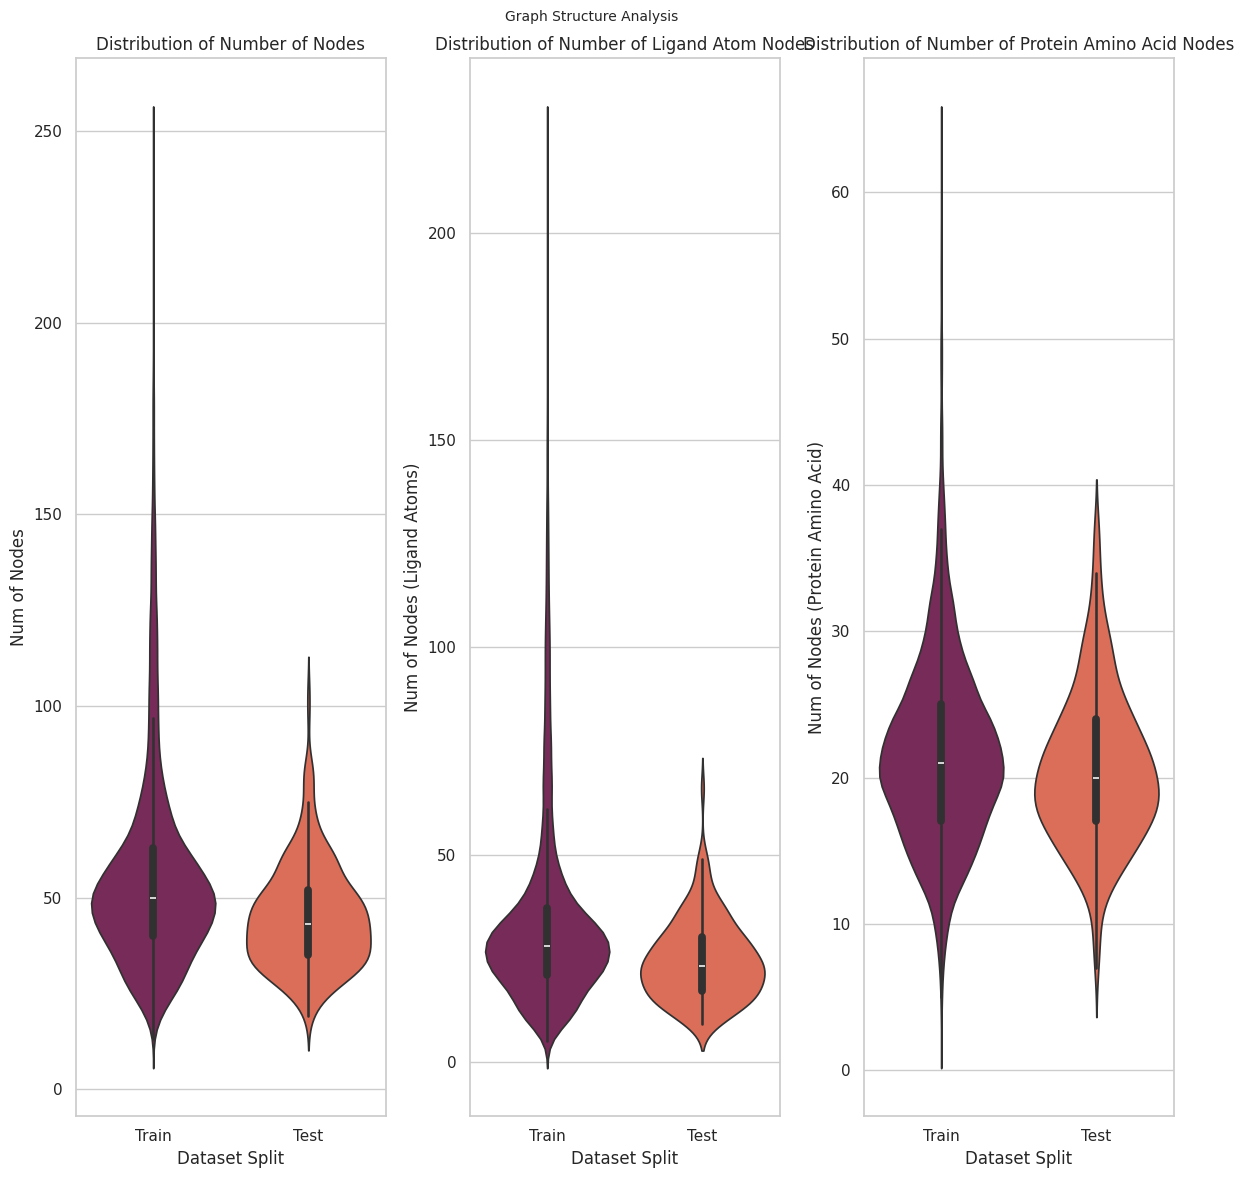

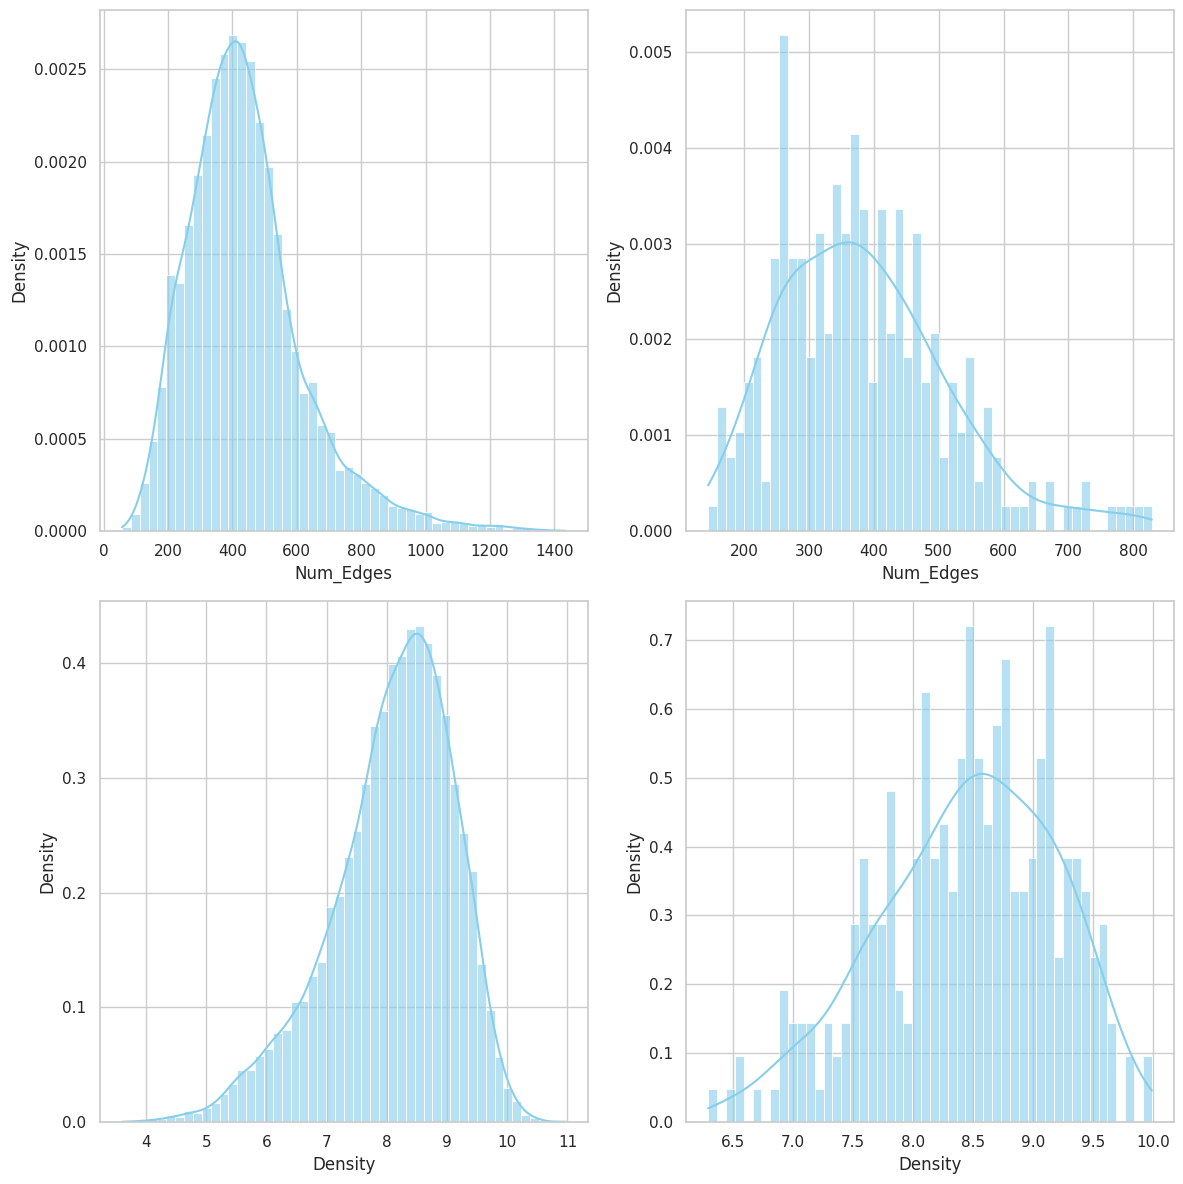

In [58]:
graph_structure_analysis(aggregated_data_df)
graph_structure_analysis_histplots(aggregated_data_df)

### Distribution of Number of Nodes
Interpretation: Violin plot shows the spread and density of the atom counts.  If the median and interquartile range for the Test set aligns closely with the train set, it suggests the model will be evaluated on molecules of similar structural complexity to those it was trained on, minimizing generalization risk due to size disparity

### Distribution of Edge Counts
Interpretation: The comparison of edge counts (bonds) verifies that the complexity of connectivity is balanced.  Significant differences in edge distribution could mean the test set contains graphs that are either much denser or much sparser than the training data, leading to a breakdown of GNN performance that relies on stable message passing

## Node Feature Analysis

Goal: compare the frequency of different atom types or node features

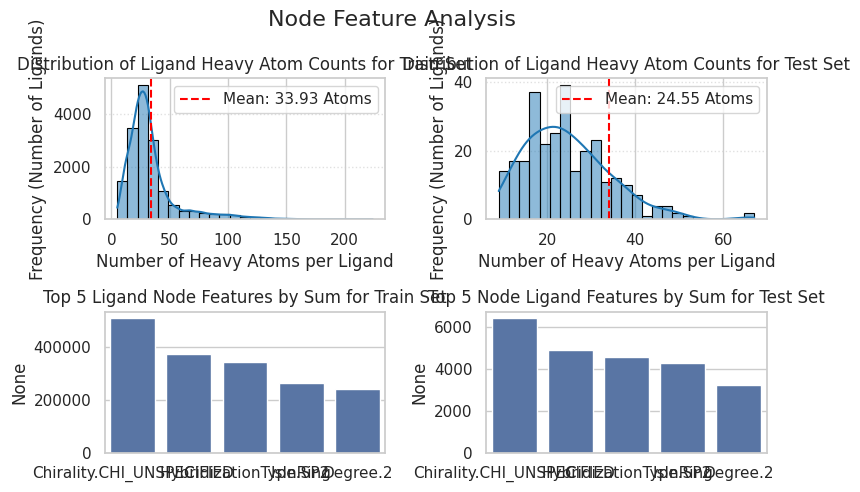

In [68]:
def node_feature_analysis(node_features_df):
    train_node_features_df = node_features_df[node_features_df['Dataset_Type']=='Train']
    test_node_features_df = node_features_df[node_features_df['Dataset_Type']=='Test']

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))
    fig.suptitle('Node Feature Analysis', fontsize=16)
    sns.histplot(
      data=train_node_features_df,
      x='Num_Ligand_Heavy_Atoms',
      kde=True,
      bins=25,
      color='#1f77b4',
      edgecolor='black',
      linewidth=0.8,
      ax=axs[0,0]
    )

    heavy_atom_mean_count_train = train_node_features_df['Num_Ligand_Heavy_Atoms'].mean().item()
    axs[0,0].set_title(f'Distribution of Ligand Heavy Atom Counts for Train Set')
    axs[0,0].set_xlabel('Number of Heavy Atoms per Ligand', fontsize=12)
    axs[0,0].set_ylabel('Frequency (Number of Ligands)', fontsize=12)
    axs[0,0].axvline(heavy_atom_mean_count_train, color='red', linestyle='--', label=f'Mean: {heavy_atom_mean_count_train:.2f} Atoms')
    axs[0,0].legend()
    axs[0,0].grid(axis='y', linestyle=':', alpha=0.6)


    sns.histplot(
      data=test_node_features_df,
      x='Num_Ligand_Heavy_Atoms',
      kde=True,
      bins=25,
      color='#1f77b4',
      edgecolor='black',
      linewidth=0.8,
      ax=axs[0,1]
    )
    heavy_atom_mean_count_test = test_node_features_df['Num_Ligand_Heavy_Atoms'].mean().item()
    axs[0,1].set_title(f'Distribution of Ligand Heavy Atom Counts for Test Set')
    axs[0,1].set_xlabel('Number of Heavy Atoms per Ligand', fontsize=12)
    axs[0,1].set_ylabel('Frequency (Number of Ligands)', fontsize=12)
    axs[0,1].axvline(heavy_atom_mean_count_train, color='red', linestyle='--', label=f'Mean: {heavy_atom_mean_count_test:.2f} Atoms')
    axs[0,1].legend()
    axs[0,1].grid(axis='y', linestyle=':', alpha=0.6)

    top_5_features_train = train_node_features_df[LIGAND_FEATURE_MAP].sum().nlargest(5).index.tolist()
    #plt.figure(figsize=(10, 6))
    sns.barplot(x=top_5_features_train, y=train_node_features_df[LIGAND_FEATURE_MAP][top_5_features_train].sum(), ax=axs[1,0])
    axs[1,0].set_title('Top 5 Ligand Node Features by Sum for Train Set')

    top_5_features_test = test_node_features_df[LIGAND_FEATURE_MAP].sum().nlargest(5).index.tolist()
    #plt.figure(figsize=(10, 6))
    sns.barplot(x=top_5_features_test, y=test_node_features_df[LIGAND_FEATURE_MAP][top_5_features_test].sum(), ax=axs[1,1])
    axs[1,1].set_title('Top 5 Node Ligand Features by Sum for Test Set')

    plt.tight_layout()
    plt.show()

node_feature_analysis(node_features_df)

Interpretation: This analysis ensures feature diversity is consistent across the split.  A large discrepancy in the count of a critical feature in the test set compared with the training set indicates a potential bias.  The model might fail to correctly process those feature types in the test set if it hasn't seen enough examples during training

### Edge Feature Analysis

#### Distribution of Number of Edges (Bond Count)

Goal: Compare the number of connections in the graphs (related to graph density)

In [ ]:
def edge_feature_analysis(edge_features_df)
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))
    fig.suptitle('Edge Feature Analysis', fontsize=16)
    plt.figure(figsize=(10, 6))
    corr_matrix_train = edge_features_df[edge_features_df['Dataset_Type']=="Train"].corr()
    sns.heatmap(corr_matrix_train, ax=axs[0], annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap of Edge Features for Train Set')

    corr_matrix_test = edge_features_df[edge_features_df['Dataset_Type']=="Test"].corr()
    sns.heatmap(corr_matrix_test, ax=axs[1], annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap of Edge Features for Test Set')

    top_5_features = edge_features_df.sum().nlargest(5).index.tolist()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_5_features, y=edge_features_df[top_5_features].sum(), ax=axs[2])
    plt.title('Top 5 Edge Features by Sum')

    plt.tight_layout()
    plt.show()

edge_feature_analysis(edge_features_df)

PCA Scatter plots?